[Forecasting: Principles and Practice](https://otexts.com/fpp2/)

## Agenda

[0.0 Loading Data](#0.0-Loading-Data)<br>

[1.0 Decomposition](#1.0-Decomposition)<br>
&nbsp;[1.2 Monthly](#1.2-Monthly)<br>

[2.0 Stationarity](#2.0-Stationarity)<br>

[3.0 Autocorrelation](#3.0-Autocorrelation)<br>

[4.0 Partial Autocorrelation](#4.0-Partial-Autocorrelation)<br>


[6.0 ARIMA](#6.0-ARIMA)<br>
&nbsp;[Finding Best P, D, Q](#Finding-Best-P,-D,-Q)<br>
&nbsp;[6.1 Model used in the Project](#6.1-Model-used-in-the-Project)<br>

[7.0 Model Adjustments](#7.0-Model-Adjustments)<br>
&nbsp;[7.1 Stationarity](#7.1-Stationarity)<br>

[8.0 Residuals Analysis](#8.0-Residuals-Analysis)<br>

In [1]:
from notebook_utils.utils import *
from notebook_utils.ml_utils import *

import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima.model import ARIMA

import itertools
import warnings

from sklearn.metrics import mean_squared_error

In [2]:
directory = Directory("1.2-pr-sales-prediction-time-series-analysis-STUDIES")

In [3]:
def fig(x=15, y=5):
    plt.rcParams['figure.figsize'] = (x, y)

## 0.0 Loading Data

In [4]:
# data_frame_to_process = pd.read_pickle(os.path.join(os.path.join(directory.DATA_DIR, "sales_forecast_data"), "ml_data_to_preprocess.pkl"))
# data_frame_to_process['revenue'] = data_frame_to_process['freight_value'] + data_frame_to_process['price']
# df = data_frame_to_process.groupby([data_frame_to_process['order_purchase_timestamp'].dt.date])[['revenue']].sum()
# df.index = pd.to_datetime(df.index)
# df.head()

In [5]:
df = pd.read_pickle(os.path.join(os.path.join(directory.DATA_DIR, 'sales_forecast_data'), 'olist_2017_forecasts_table_model.pkl'))
dates_index = ['2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
               '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31',
               '2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31']
df.index = pd.to_datetime(dates_index)
annual_forecast = df.copy()
df.round(2)

,known_revenue,estimated_revenue
2017-01-31,127482.37,15551.25
2017-02-28,271239.32,57997.55
2017-03-31,414330.95,132913.77
2017-04-30,390812.40,271017.55
2017-05-31,566851.40,358794.22
2017-06-30,490050.37,457331.58
2017-07-31,566299.08,482571.39
2017-08-31,645832.36,541066.95
2017-09-30,701077.49,567393.94
2017-10-31,751117.01,637736.31


## 1.0 Decomposition

Time series with **trend**, or with **seasonality**, are not stationary

We want the residuals to be as small as possible.

        Season = SARIMA
        
        Seasonal: less than 1 year.
        Cyclical: more than 1 year.


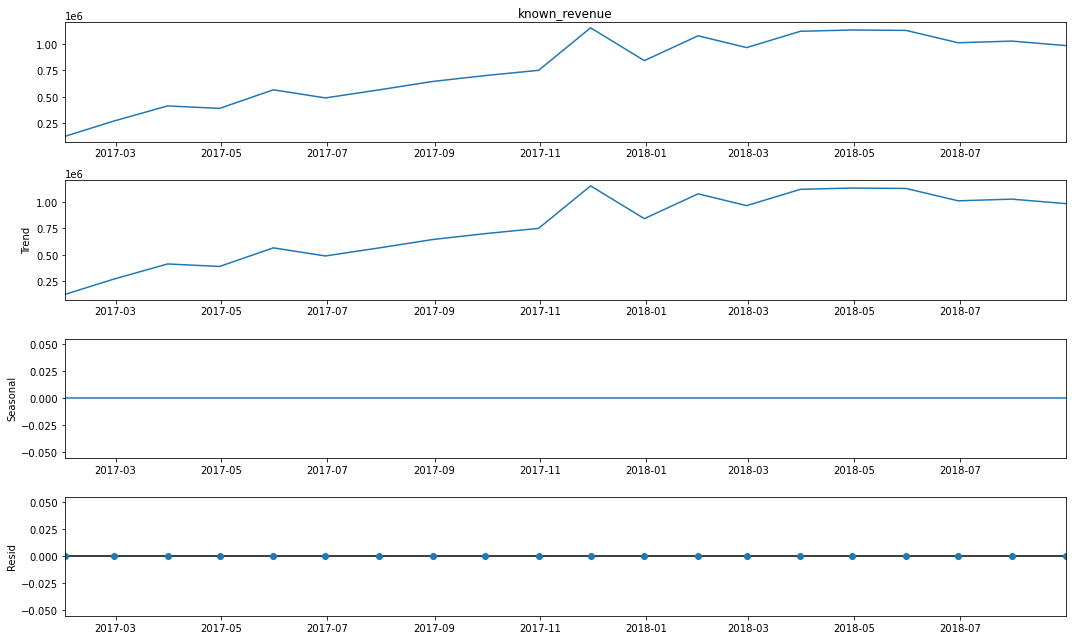

In [6]:
fig(15, 9)
decomposition = seasonal_decompose(df['known_revenue'], period=1)
decomposition.plot()
plt.show()

## 2.0 Stationarity

**A stationary time series is one whose properties do not depend on the time at which the series is observed.<br> 
Thus, time series with trends, or with seasonality, are not stationary**

_Mean and variance are constant over a long time period._

<a href="https://machinelearningmastery.com/time-series-data-stationary-python/" target="_blank"><strong>Stationary: p-value <= 0.05</strong></a>

In [7]:
result = adfuller(df['known_revenue'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Stationary:', (result[1] <= 0.05))
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.272699
p-value: 0.180924
Stationary: False
Critical Values:
	1%: -3.859
	5%: -3.042
	10%: -2.661


In [8]:
result = adfuller(df['known_revenue'].diff().dropna())
print('p-value: %f' % result[1])
print('Stationary:', (result[1] <= 0.05))

p-value: 0.000000
Stationary: True


In [9]:
# df['known_revenue'].diff().dropna().plot(figsize=(15,5));

## 3.0 Autocorrelation

A autocorrelação de uma série, nada mais é do que a correlação de uma série temporal com uma cópia 'atrasada' de si mesma.

**q - acp_plot**

> Autocorrelation defines AutoRegressive component (p) or P comes from PACF?

    We can use a lag of 2 when modeling a monthly time frame. (fora do intervalo de não significância
    (intervalo de confiança para o valor 0))

Autocorrelation for monthly revenue with lag equals 1: 88.0%
Autocorrelation for monthly revenue with lag equals 2: 91.0%
Autocorrelation for monthly revenue with lag equals 3: 83.0%
Autocorrelation for monthly revenue with lag equals 4: 81.0%
Autocorrelation for monthly revenue with lag equals 5: 75.0%
Autocorrelation for monthly revenue with lag equals 6: 76.0%
Autocorrelation for monthly revenue with lag equals 7: 53.0%


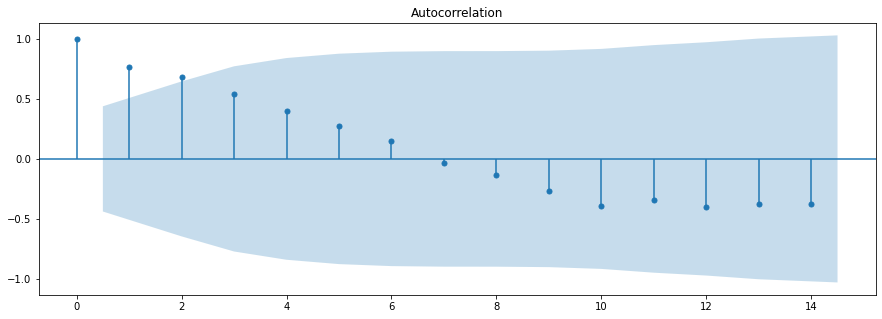

In [10]:
for lag in range(1, 8):
    autocorrelation = df['known_revenue'].autocorr(lag)
    print(f"Autocorrelation for monthly revenue with lag equals {lag}: {np.round(autocorrelation*100)}%" )

fig(15, 5)
plot_acf(df['known_revenue'], alpha = 0.05);

In [11]:
# lag = 2 # 13
# fig(15,4)

# plt.scatter(df['known_revenue'], df['known_revenue'].shift(lag))
# plt.show()
# df['known_revenue'].plot()
# df['known_revenue'].shift(lag).plot();

**diff**

In [12]:
# plot_acf(df['known_revenue'].diff().dropna(), alpha = 0.05);

## 4.0 Partial Autocorrelation

> Partial Autocorrelation defines Moving average component (q) or o	ACF gives q?

**P - current value of y is dependent on how many previous lagged.**

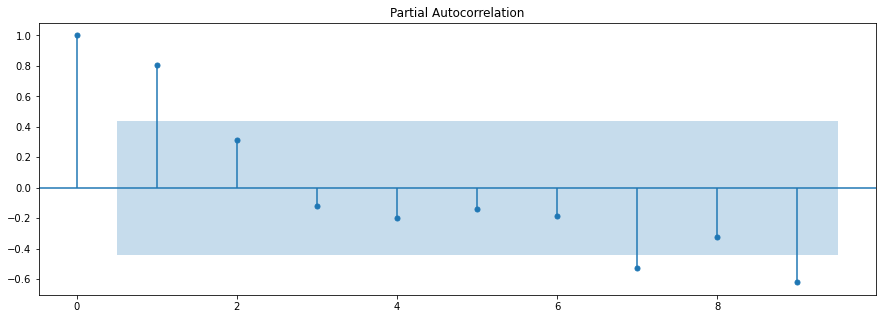

In [13]:
plot_pacf(df['known_revenue'], lags=9, alpha = 0.05);

**diff**

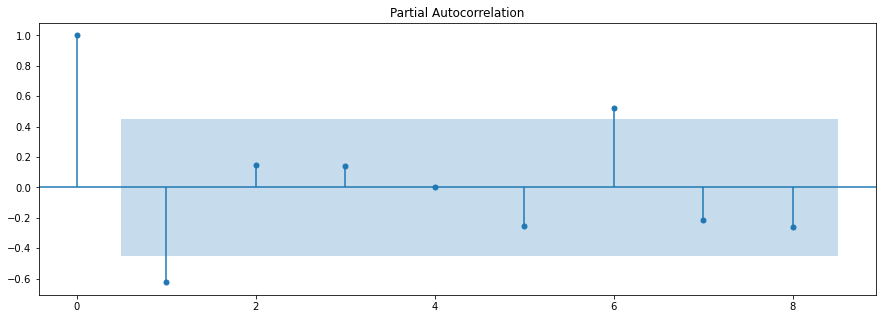

In [14]:
plot_pacf(df['known_revenue'].diff().dropna(), lags=8, alpha = 0.05);

## 5.0 Transformations

Removing Trend

## 6.0 ARIMA

**Autoregressive component:** AR stands for autoregressive.  Autoregressive parameter is denoted by p.  When p =0, it means that there is no auto-correlation in the series.  When p=1, it means that the series auto-correlation is till one lag.
    
    	Future values of Y is dependent of {N} lag values of Y.

**Integrated:** In ARIMA time series analysis, integrated is denoted by d.  Integration is the inverse of differencing.  When d=0, it means the series is stationary and we do not need to take the difference of it.  When d=1, it means that the series is not stationary and to make it stationary, we need to take the first difference.  When d=2, it means that the series has been differenced twice.  Usually, more than two time difference is not reliable.

**Moving average component:** MA stands for moving the average, which is denoted by q.  In ARIMA, moving average q=1 means that it is an error term and there is auto-correlation with one lag.

        Future values of Y is dependent of previous lagged values of white noise ie the irregular component.
        white noise is just  the error. error is the differerence between the actual value and predicted value.
        So we take into considerration the error also to predict the future value.
        
        Autocorrelation between the errors.


**Train - Test - Validation Set**

In [15]:
training_data = df.loc['2017-01-31':'2018-03-31', 'known_revenue']
testing_data = df.loc['2018-04-30':'2018-06-30', 'known_revenue']
production_data = df.loc['2018-07-31':, 'known_revenue']

final_training_data = df.loc['2017-01-31':'2018-06-30', 'known_revenue']

## Finding Best P, D, Q

In [70]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    p = range(0, 8)
    q = range(0, 8)
    d = range(0, 2)

    pdq_combination = list(itertools.product(p,d,q)) # 128 combinations

    rmse = []
    index = []

    for pdq in pdq_combination:
        try:
            model = ARIMA(training_data.values, order=(pdq)).fit()
            predictions = model.forecast(len(testing_data))
            error = np.sqrt(mean_squared_error(testing_data, predictions) # Your Metric - mean_squared_error
            index.append(pdq)
            rmse.append(error)
        except:
            continue

In [71]:
pdq_parameters = pd.DataFrame(data=rmse, columns=['rmse'], index=pd.Series(index, name='pdq')).sort_values('rmse')

### 6.1 Model used in the Project

In [25]:
def train_test_arima(autoregressive_component, integrated, moving_average_component, return_models=False, evaluate=True):
    p, d, q = autoregressive_component, integrated, moving_average_component
    
    model = ARIMA(training_data.values, order=(p, d, q)).fit()
    if evaluate:
        evaluation(testing_data, model.forecast(3), "2nd Quarter of 2018")
        print()
    
    final_model = ARIMA(final_training_data.values, order=(p, d, q)).fit()
    if evaluate:
        evaluation(production_data, final_model.forecast(2), "3rd Quarter of 2018")
    
    if return_models: return model, final_model

In [26]:
train_test_arima(2, 0, 0)

2nd Quarter of 2018
On average, our predictions are 5.7% above or below the real value.
Which means an error of about R$ 64,127.08

3rd Quarter of 2018
On average, our predictions are 3.18% above or below the real value.
Which means an error of about R$ 31,915.91


## 7.0 Model Adjustments

### 7.1 Stationarity

Our series is not [2.0 Stationarity](#2.0-Stationarity). Then:


_integrated is denoted by d._

_When d=1, it means that the series is not stationary and to make it stationary,_

In [27]:
train_test_arima(2, 1, 0) # q from diff

2nd Quarter of 2018
On average, our predictions are 4.82% above or below the real value.
Which means an error of about R$ 52,517.09

3rd Quarter of 2018
On average, our predictions are 0.63% above or below the real value.
Which means an error of about R$ 6,370.43


In [ ]:
# train_test_arima(2, 1, 1) # partial autocorrelation q

<strong>O que o rapaz disse sobre:</strong>

<font color="grey">

_Autocorrelation defines moving average component._

_Partial Autocorrelation defines autoregressive component._


<strong>Outspoken:</strong>

_Autocorrelation = autoregressive component_
</font>

In [ ]:
# fig()
# plot_acf(df['known_revenue'], alpha = 0.05);
# plot_pacf(df['known_revenue'], lags=9, alpha = 0.05);

In [62]:
train_test_arima(1, 1, 2)

2nd Quarter of 2018
On average, our predictions are 7.23% above or below the real value.
Which means an error of about R$ 77,695.68

3rd Quarter of 2018
On average, our predictions are 1.76% above or below the real value.
Which means an error of about R$ 17,508.07


**Best PDQ Search**

In [74]:
pdq_parameters.head(10).T # (2, 1, 0) in top 10

pdq,"(6, 1, 3)","(7, 1, 2)","(5, 1, 3)","(2, 1, 3)","(0, 1, 0)","(3, 0, 2)","(4, 0, 2)","(7, 0, 2)","(3, 0, 1)","(2, 1, 0)"
rmse,43025.594586,43025.604571,43025.607274,43025.614168,43025.64,50501.887383,51181.685864,51804.944259,52428.097901,52517.093694


In [69]:
train_test_arima(6, 1, 3)

C:\Users\WALDENIO_NOT\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\WALDENIO_NOT\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


2nd Quarter of 2018
On average, our predictions are 4.18% above or below the real value.
Which means an error of about R$ 43,025.59



C:\Users\WALDENIO_NOT\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\WALDENIO_NOT\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


3rd Quarter of 2018
On average, our predictions are 2.11% above or below the real value.
Which means an error of about R$ 21,157.82


## 8.0 Residuals Analysis

In [28]:
model_p, model_p_final = train_test_arima(2, 0, 0, return_models=True, evaluate=False)
final_model, final_model_final = train_test_arima(2, 1, 0, return_models=True, evaluate=False)

In [ ]:
# print(final_model_final.summary())

So what?

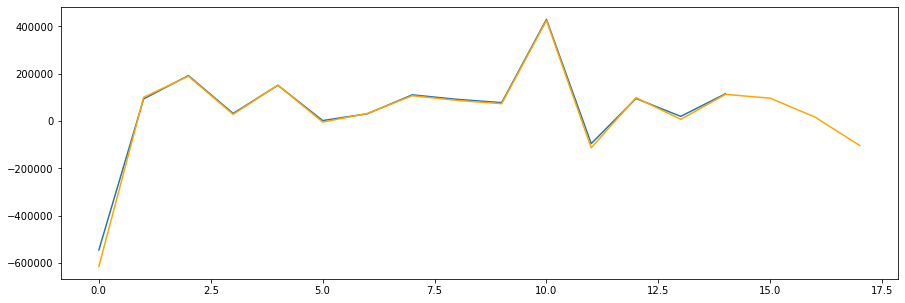

In [29]:
# Lower the better
pd.Series(model_p.resid).plot();
pd.Series(model_p_final.resid).plot(color='orange');

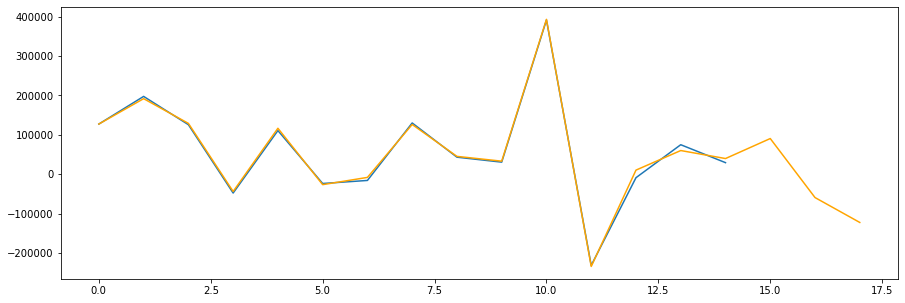

In [30]:
pd.Series(final_model.resid).plot();
pd.Series(final_model_final.resid).plot(color='orange');

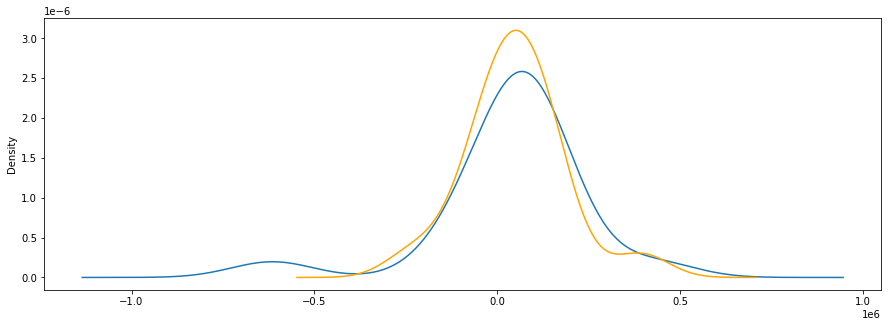

In [31]:
# Must be not skewed
pd.Series(model_p_final.resid).plot(kind='kde');
pd.Series(final_model_final.resid).plot(kind='kde', color='orange');

In [32]:
# Mean Close to 0
display(pd.DataFrame(model_p_final.resid).describe().T.round(2))
display(pd.DataFrame(final_model_final.resid).describe().T.round(2))

,count,mean,std,min,25%,50%,75%,max
0,18.0,38379.48,200459.75,-614729.91,9491.17,80332.95,105359.32,425138.65


,count,mean,std,min,25%,50%,75%,max
0,18.0,48406.84,133851.96,-234081.51,-21794.36,42647.57,123970.56,393323.55


- Posso usar esse esquema para outros projetos? O que acrescentar? O que fazer diferente?
